In [1]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

In [ ]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

In [ ]:
%pip install -qU "langchain[google-genai]" --use-deprecated=legacy-resolver

In [ ]:
%pip install -qU langchain-google-genai

In [ ]:
%pip install -qU langchain-chroma 

In [ ]:
#%%skip
#I had some problems running this on my mac. Make sure you use this if you need to
%pip uninstall -y protobuf
%pip install protobuf==3.20.3

In [ ]:
%pip install python-dotenv

In [ ]:
%pip install urllib3==1.26.18

In [ ]:
%pip install -qU langchain_community pymupdf

In [2]:
import getpass
import os
from dotenv import load_dotenv
load_dotenv()

#Here we just load in all the API keys and choose what AI model we want to run. 
#We setup the vector store and embeddings to later store our indices into to retrieve later.

os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter Langsmith API Key")

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

print("YAY")

YAY


In [3]:
#Load papers 
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.documents import Document

directory = "dnutg"
all_docs = []
for file in os.listdir(directory):
    if file.endswith(".pdf"):
        file_path = os.path.join(directory, file)
        print(f"Loading the {file_path} now...")
        loader = PyMuPDFLoader(file_path, mode="page", extract_tables="markdown",)

        try:
            current_doc = loader.load()
            all_docs.extend(current_doc)
        except Exception as e:
            print(f"Error in loading the file")
print(f"Finished loading {len(all_docs)} documents")

    

Loading the dnutg\00007256-200333070-00004.pdf now...
Loading the dnutg\0003-4819-118-6-199303150-00008.pdf now...
Loading the dnutg\paper1.pdf now...
Finished loading 43 documents


In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, #chunk size
    chunk_overlap=200, #chunk overlap
    add_start_index=True, #track index
)
all_splits = text_splitter.split_documents(all_docs)
print(f"Split dem cheeks boi (into a diclosed number of subdocs): {len(all_splits)} sub-documents.")

Split dem cheeks boi (into a diclosed number of subdocs): 278 sub-documents.


In [5]:
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids[:3])

['e7129c25-9548-4b3b-bfb4-ae2301b669b5', '389a9b16-a0c5-490d-8f3d-65afd1cd26cf', '2a329cec-0222-489b-9938-bb757f72d950']


In [6]:
from langchain_core.prompts import ChatPromptTemplate

prompt_template = """You are a highly knowledgeable AI assistant specializing in cardiovascular health and medical research.
Your primary goal is to provide accurate, evidence-based answers to user questions about heart rate, heart health, and related medical conditions.

Answer the question ONLY based on the following context. If the answer cannot be found in the context, please respond to the best of your given ability with the context. You don't have to answer the question if you cannot, but try to give as much context to answering the question as possible. Do not make up information.

Context:
{context}

Question:
{question}
"""

prompt = ChatPromptTemplate.from_template(prompt_template)

sample_context = """
A study on resting heart rate found that a rate between 60-100 is normal.
"""

sample_question = "What is a good heart rate?"

prompt_value = prompt.invoke({"context":sample_context, "question":sample_question})

example_messages = prompt_value.to_messages()
assert len(example_messages) == 1
#print(example_messages[0].content)


In [7]:
%%skip
#Query analysis: optimize user prompts to make sense to llm
total_docs = len(all_splits)
third = total_docs // 3
for i, doc in enumerate(all_splits):
    if i<third:
        doc.metadata["section"] = "begin"
    elif i<2*third:
        doc.metadata["section"] = "mid"
    else:
        doc.metadata["section"] = "end"


In [8]:
#update docs in the vector store
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [9]:
#Model for state of HumMsg -> AIMsg -> ToolMsg -> AIMsg
#Also augments queries w tools
from langgraph.graph import MessagesState, StateGraph, END
from langchain_core.tools import tool

graph_builder = StateGraph(MessagesState)
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [10]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from langgraph.checkpoint.memory import MemorySaver

#gen AI message that could include tool-call
def query_or_respond(state: MessagesState):
    """Gen tool call for retrieval or prep for llm to respond"""
    llm_wtool = llm.bind_tools([retrieve])
    response = llm_wtool.invoke(state["messages"])
    """MessagesState appends messages to state instead of overwrite"""
    return {"messages":[response]}

#then execute retrieval
tools = ToolNode([retrieve])

#gen response w retrieved content
def generate(state: MessagesState):
    #get tool msgs
    recent_tmsgs = []
    for message in reversed(state['messages']):
        if message.type == "tool":
            recent_tmsgs.append(message)
        else:
            break
    tmsgs = recent_tmsgs[::-1]

    #format into prompt
    docs_words = "\n\n".join(doc.content for doc in tmsgs)
    system_msg = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_words}"
    )
    convo = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_msg)] + convo

    #run
    response = llm.invoke(prompt)
    return {"messages": [response]}

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
agent = create_react_agent(llm, [retrieve], checkpointer=memory)

graph = graph_builder.compile(checkpointer=memory)
#put an ID to the thread
config = {"configurable": {"thread_id": "abc101"}}


In [11]:
%%skip
#define schema for search query using structured output
from typing import Literal
from typing_extensions import Annotated, List, TypedDict

class Search(TypedDict):
    """Search Query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["begin", "mid", "end"],
        ...,
        "Section to query."
    ]
    

In [12]:
%%skip
#We use langGraph to tie together retrievel and generation into simpler process
#Makes it easier to update later + easy to trace steps of the application
from langgraph.graph import START, StateGraph, MessagesState


class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter = lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

#now make graph object that compiles all components into one
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

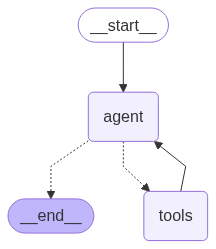

In [19]:
#workflow display
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [27]:
input_message = (
    "How can I use this learning in my own life?"
    
)

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How can I use this learning in my own life?
================================== Ai Message ==================================
Tool Calls:
  retrieve (a6817b85-a050-470f-a185-2209be28c32a)
 Call ID: a6817b85-a050-470f-a185-2209be28c32a
  Args:
    query: how can heart rate variability be used in daily life
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'Acrobat Distiller 7.0.5 pour Macintosh', 'creator': 'Elsevier', 'creationdate': '2016-07-18T16:22:02+05:30', 'source': 'dnutg\\paper1.pdf', 'file_path': 'dnutg\\paper1.pdf', 'total_pages': 8, 'format': 'PDF 1.7', 'title': 'Determinants of heart rate variability', 'author': 'Hisako Tsuji', 'subject': 'Journal of the American College of Cardiology, (1996) 1539-1546. doi:10.1016/S0735-1097(96)00342-7', 'keywords': '', 'moddate': '2016-07-18T16:22:02+05:30', 'trapped': '', 'modDate': "D:20160

In [15]:
%%skip
#test app
result = graph.invoke({"question": "My heart rate usually rests between 60 to 90. Am I in danger of anything?"})
#print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

In [16]:
%%skip
#testing the app using diff method. This one is streaming
for step in graph.stream(
    {"question": "What is a heart?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

In [17]:
%%skip
#Uses stream tokens?? idk 
for message, metadata in graph.stream(
    {"question": "What is a heart rate variability?"}, stream_mode="messages"
):
    print(message.content, end="|")